<img src="img/banner.png" width = 90%>


## Transfer Learning : classification d‚Äôimages m√©dicales √† partir de mod√®les pr√©-entra√Æn√©s de type CNN.

Projet de mise en place d'un syst√®me de classification binaire permettant de d√©tecter des cas de pneumonie √† partir de radios thoraciques, via utilisation d'un *mod√®le de vision par ordinateur pr√©entra√Æn√©* type *CNN*. Utilisation du dataset *Chest X-Ray Pneumonia*.

Appr√©hension d'une d√©marche de suivi des exp√©rimentations par *MLflow*, afin de tracer les param√®tres d‚Äôentra√Ænement, les m√©triques de performance et les versions de mod√®le.

**Contexte du projet** : Une √©quipe m√©dicale souhaite tester l‚Äôapport de l‚Äôintelligence artificielle dans le diagnostic automatis√© de la pneumonie √† partir de radios thoraciques. Elle a besoin d‚Äôun prototype fonctionnel (Proof of Concept) permettant de d√©montrer la faisabilit√© d‚Äôun syst√®me de classification binaire d‚Äôimages m√©dicales.

_______________________________________________________________________________________________________________________________________________________

### Import des biblioth√®ques

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import class_weight
import mlflow
import random

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

#from tensorflow.keras.applications import DenseNet121   # DenseNet121 = mod√®le tr√®s utilis√© dans le domaine m√©dical pour la d√©tection
                                                        # de maladies pulmonaires. Test√©, mais tr√®s lourd sur le processeur.

from tensorflow.keras.applications import MobileNetV3Large  # MobileNetV3 = mod√®le CNN plus g√©n√©ral, mais plus l√©ger
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input     # fonction pr√©conis√©e pour la normalisation des donn√©es avec MobileNetV3




np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30)

# 1. Exploration des donn√©es

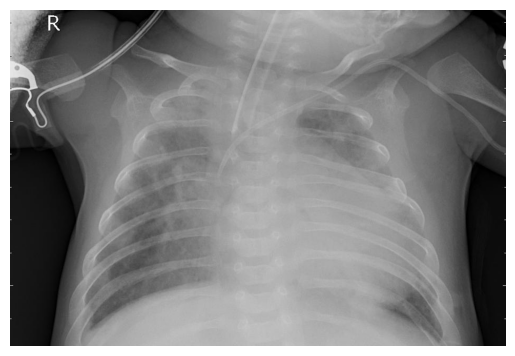

Shape (dimensions) : (640, 944, 3)
Type des valeurs : uint8


In [2]:
img = cv2.imread("data/test/PNEUMONIA/person1_virus_6.jpeg", cv2.IMREAD_COLOR_RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Shape (dimensions) : {img.shape}")
print(f"Type des valeurs : {img.dtype}")

En testant l'affichage de plusieurs images et leurs dimensions, nous pouvons voir que les radios sont de formats diff√©rents.

_______________________________________________________________________________________________________________________________________________________

# 2. Pr√©paration des donn√©es et pr√©processing

**MobileNetV3Large et ImageDataGenerator :**
 
- Plus le format d'image est grand, plus il sera performant.
- Nous cr√©ons un **ImageDataGenerator**, qui permettra de pr√©traiter et normaliser nos images pour le mod√®le, ainsi que de faire de la Data Augmentation (rotation, zoom, miroir, etc.) pour √©viter l'overfitting. (*Normalement, cela permet √©galement de charger nos images depuis les dossier afin d'√©viter de tout charger en m√©moire, et de les redimensionner. J'ai cependant fait le choix ici de le faire par la fonction get_train_test() afin de pouvoir filtrer les images illisibles sans les supprimer.*)
- Utilisation de la fonction **preprocess_input** d√©di√©e √† la normalisation des donn√©es pour MobileNetV3.
\
\
*A noter : ici les donn√©es sont au pr√©alable s√©par√©es en dossiers test, train, et val pour faciliter le travail.*


In [3]:
def resize_with_padding(img, target_size = (224, 224, 3)):
        """ Fonction permettant de redimensionner les images √† la m√™me taille tout en gardant leur ratio,
            en ajoutant un padding noir quand n√©cessaire.        
        """
        
        h, w = img.shape[:2]
        scale = min(target_size[0]/h, target_size[1]/w)
        new_h, new_w = int(h * scale), int(w * scale)
        resized = cv2.resize(img, (new_w, new_h))

        padded = np.zeros(target_size, dtype=np.uint8)

        y_offset = (target_size[0] - new_h) // 2
        x_offset = (target_size[1] - new_w) // 2

        padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
        return padded

In [4]:
def get_train_test(base_path: str):
    """ Fonction parcourant les dossiers de nos datas afin de les charger et les s√©parer en deux tableaux Numpy (X pour les images,
        y pour les labels), et v√©rifiant si l'image est lisible ou non. Appel la fonction resize_with_padding afin de les redimensionner.
    """
    
    X = [] # images
    y = [] # labels
    label_to_int = {"NORMAL" : 0, "PNEUMONIA" : 1}

    for label in sorted(os.listdir(base_path)):
        label_path = os.path.join(base_path, label)

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_COLOR_RGB)
            if img is None:
                print("Image illisible : ", file_path)
                continue
            img = resize_with_padding(img)
            X.append(img)
            y.append(label_to_int[label])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

Cr√©ation des datagen avec ImageDataGenerator :

In [5]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

Cr√©ation de nos diff√©rents sets de donn√©es :

In [6]:
X_train, y_train = get_train_test("data/train")
X_test, y_test = get_train_test("data/test")
X_val, y_val = get_train_test("data/val")

X_test_display = X_test.copy()      # pour garder une copie de l'image d'origine afin de l'afficher lors de la pr√©diction

Application des datagen :

In [7]:
train_generator = datagen.flow(X_train, y_train, batch_size=32)
valid_generator = datagen.flow(X_val, y_val, batch_size=32)
test_generator = datagen.flow(X_test, y_test, batch_size=32)

Visualisation des 10 premi√®res radios pour v√©rifier le fonctionnement du traitement pr√©c√©dent.

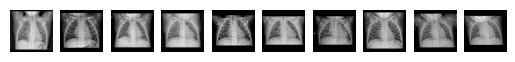

In [8]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis("off")

plt.show()

R√©√©quilibre des classes afin d'am√©liorer l'apprentissage. Evite au mod√®le de favoriser les classes majoritaires.

In [9]:
def compute_class_weights(y):
    """ Fonction permettant de calculer le poids des classes afin de les r√©√©quilibrer    
    """
    
    # Calculer les poids de classe
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',    # equilibre automatiquement selon la fr√©quence
        classes=np.unique(y),       # classes pr√©sentes
        y=y)    # vecteur des labels
    
    # Cr√©er un dictionnaire de poids
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    return class_weight_dict


In [10]:
# Utilisation de la fonction pour calculer les poids des classes sur nos donn√©es
class_weights = compute_class_weights(y_train)

_______________________________________________________________________________________________________________________________________________________

# 3. Mod√©lisation

### a. Importation du mod√®le, param√©trage, et compilation

Nous cr√©ons le mod√®le sur la base du mod√®le pr√©-entra√Æn√© **MobileNetV3Large**, mod√®le CNN performant sur la classification d'images.\
Nous importons le mod√®le avec ses *poids pr√©-entra√Æn√©s* (*ImageNet*). Avant cela nous normalisons les donn√©es avec la fonction d√©di√©e *preprocess_input*.\
Nous n'utilisons pas la derni√®re couche du mod√®le (*include-top = False*) afin d'ajouter celles qui nous int√©ressent pour le r√©sultat que nous recherch√© (*model_outputs*).

__DenseNet121__, pr√©cedemment test√©, est tr√®s utilis√© dans le domaine m√©dical notamment dans la d√©tection de maladie pulmonaires, mais il demande beaucoup de performances au processeur pour faire ses calculs. Malgr√© des r√©sultats moins √©lev√©s, j'utilise un mod√®le plus l√©ger pour raisons p√©dagogiques. Pour sa pr√©paration :
- Les images devaient √™tre redimensionn√©es au format *224 x 224*.
- Nous convertissons le format *int* des pixels de nos images en *float32*, pour ensuite normaliser nos donn√©es en les divisant par 255 (pour passer la valeur des pixels entre 0 et 1)
- Nous l'importions √©galement avec les poids *ImageNet*, et les donn√©es √©taient normalis√©es avec une certaine moyenne et un certain √©cart-type, les m√™mes que lors de l'entra√Ænement initial du mod√®le.

In [11]:
# choix des param√®tres de compilation

optimizer = 'adam'
loss_function = 'binary_crossentropy'

In [12]:

inputs = Input(shape=(224, 224, 3))

# Importation du mod√®le avec les poids pr√©-entra√Æn√© d'ImageNet, et en excluant la derni√®re couche (include-top=False) pour ajouter la notre
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_tensor=inputs)

# Gel des couches du mod√®le pr√©-entra√Æn√©
base_model.trainable = False

# Cr√©ation des couches hautes
model_outputs = base_model.output
model_outputs = GlobalAveragePooling2D()(model_outputs)
model_outputs = Dense(1, activation='sigmoid')(model_outputs)

# Cr√©ation du mod√®le
model = Model(inputs=inputs, outputs = model_outputs)

# Compilation du mod√®le
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

### b. R√©sum√© du mod√®le

Nous pouvons voir toutes les couches de notre mod√®le. Initialement, il ne prend pas en compte les param√®tres des couches gel√©es.

In [13]:
# model.summary()

_______________________________________________________________________________________________________________________________________________________

# 4. Entra√Ænement du mod√®le avec gel des couches basses

On d√©finit un arr√™t automatique pour √©viter le surapprentissage, et r√©duire le temps d'entra√Ænement inutile. Il servira √©galement lors de l'entra√Ænement suivant (avec plus de couches activ√©es).

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)   # Surveillance pour emp√™cher le surapprentissage

nb_epochs = 10
batch_size = 32

### a. Entra√Ænement

In [15]:
history_freeze = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=valid_generator,
    validation_steps=len(X_val) // 32,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

c:\Users\Utilisateur\Documents\PROJETS\02 - Transfer Learning\CNN_Transfer_Learning\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 85s 493ms/step - accuracy: 0.7036 - loss: 0.5318 - val_accuracy: 0.8125 - val_loss: 0.5965
Epoch 2/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79s 487ms/step - accuracy: 0.9032 - loss: 0.2391 - val_accuracy: 0.8125 - val_loss: 0.4902
Epoch 3/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 498ms/step - accuracy: 0.9251 - loss: 0.1882 - val_accuracy: 0.8125 - val_loss: 0.4764
Epoch 4/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 505ms/step - accuracy: 0.9283 - loss: 0.1777 - val_accuracy: 0.8750 - val_loss: 0.3702
Epoch 5/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78s 479ms/step - accuracy: 0.9311 - loss: 0.1754 - val_accuracy: 0.7500 - val_loss: 0.5575
Epoch 6/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 77s 473ms/step - accuracy: 0.9378 - loss: 0.1598 - val_accuracy: 

### b. Evaluation de la pr√©cision

In [16]:
loss_freeze, accuracy_freeze = model.evaluate(X_test, y_test)
print(f"Pr√©cision : {accuracy_freeze*100:.2f}%")
print(f"Pertes : {loss_freeze}")

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 280ms/step - accuracy: 0.8995 - loss: 0.2507
Pr√©cision : 90.38%
Pertes : 0.25418639183044434


_______________________________________________________________________________________________________________________________________________________

# 5. Entra√Ænement du mod√®le avec ajout de couches du mod√®le de base

Apr√®s avoir entra√Æn√© les derni√®res couches du mod√®le (que nous avons ajout√© sp√©cifiquement pour notre projet = outputs), nous d√©gelons quelques unes des derni√®res couches afin d'essayer d'optimiser au mieux les performances du mod√®le.

\
(Avec **DenseNet121** il √©tait difficilement possible d'ajouter des couches pour l'optimisation, en raison d'un manque de performances de l'ordinateur.)

### a. Mod√©lisation

In [17]:
for layer in base_model.layers[-10:]:   # ici nous d√©gelons les 10 derni√®res couches
    layer.trainable = True

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

### b. R√©sum√© du mod√®le

In [18]:
#model.summary()

### c. Entra√Ænement

In [19]:
history_nofreeze = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=valid_generator,
    validation_steps=len(X_val) // 32,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 87s 504ms/step - accuracy: 0.9405 - loss: 0.1547 - val_accuracy: 0.8750 - val_loss: 0.3762
Epoch 2/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 503ms/step - accuracy: 0.9632 - loss: 0.0918 - val_accuracy: 0.8750 - val_loss: 0.3624
Epoch 3/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 83s 506ms/step - accuracy: 0.9622 - loss: 0.1003 - val_accuracy: 0.9375 - val_loss: 0.3727
Epoch 4/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 80s 493ms/step - accuracy: 0.9702 - loss: 0.0676 - val_accuracy: 0.6875 - val_loss: 0.5495
Epoch 5/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 77s 471ms/step - accuracy: 0.9742 - loss: 0.0647 - val_accuracy: 0.9375 - val_loss: 0.1606
Epoch 6/10
163/163 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 81s 495ms/step - accuracy: 0.9699 - loss: 0.0737 - val_accuracy: 

### d. Evaluation de la pr√©cision

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pr√©cision : {accuracy*100:.2f}%")
print(f"Pertes : {loss}")

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 310ms/step - accuracy: 0.8820 - loss: 0.4639
Pr√©cision : 90.06%
Pertes : 0.3497638702392578


### e. Matrice de confusion

20/20 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 362ms/step
Classification Report :

              precision    recall  f1-score   support

      Normal       0.90      0.82      0.86       234
   Pneumonia       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



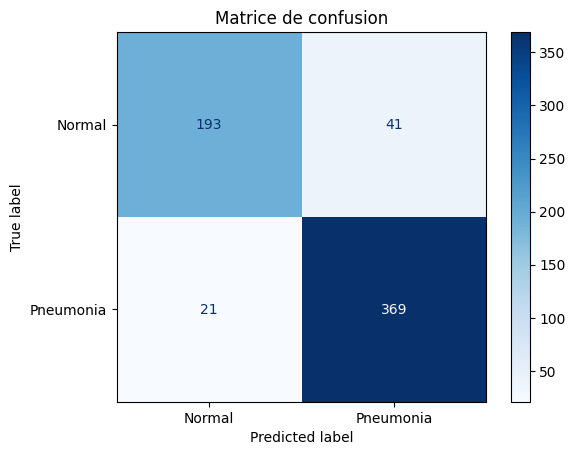

In [21]:
y_pred_proba = model.predict(X_test)

y_pred = (y_pred_proba > 0.5).astype("int32").flatten()

print("Classification Report :\n")
print(classification_report(y_test, y_pred, target_names=["Normal", "Pneumonia"]))
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()


Nous pouvons voir gr√¢ce √† l'√©valuation de la pr√©cision, au rapport de classification et √† la matrice de confusion de notre mod√®le qu'il est plut√¥t efficace.

### f. Courbe ROC

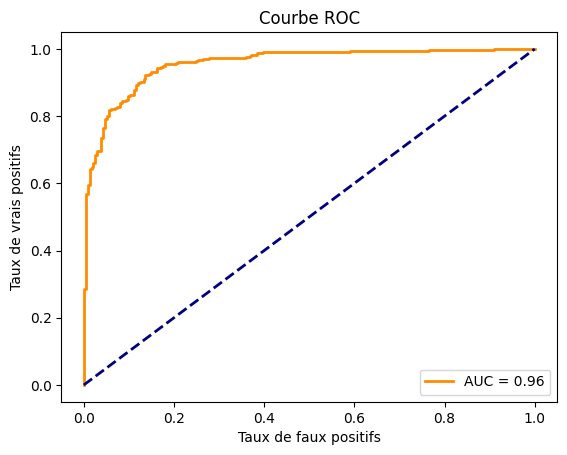

In [31]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")

### g. Courbe de v√©rification de l'overfitting

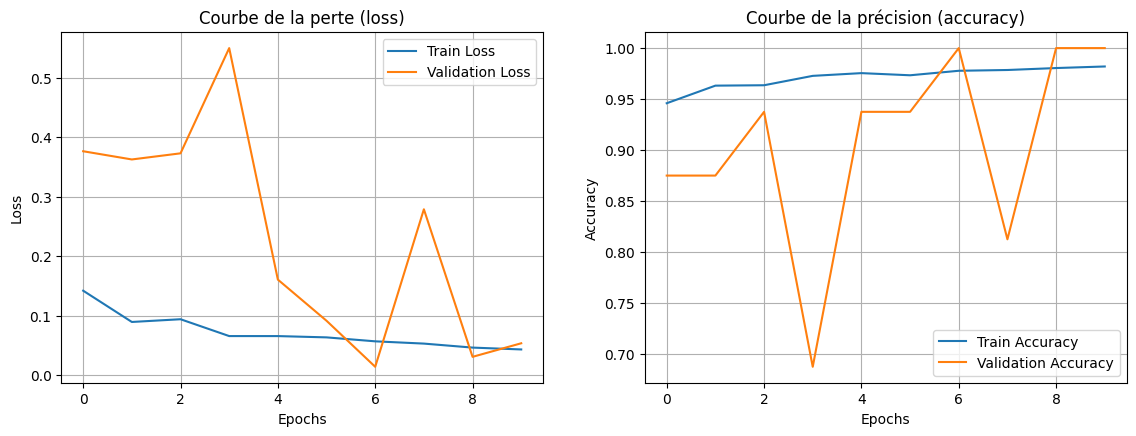

In [22]:
plt.figure(figsize=(12, 5))

# Courbe de perte (loss)
plt.subplot(1, 2, 1)
plt.plot(history_nofreeze.history['loss'], label='Train Loss')
plt.plot(history_nofreeze.history['val_loss'], label='Validation Loss')
plt.title('Courbe de la perte (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Courbe de pr√©cision (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_nofreeze.history['accuracy'], label='Train Accuracy')
plt.plot(history_nofreeze.history['val_accuracy'], label='Validation Accuracy')
plt.title('Courbe de la pr√©cision (accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout(pad=3.0)

plt.show()

Gr√¢ce √† ces courbes nous pouvons surveiller si le mod√®le entre en overfitting ou non. Le EarlyStop ajout√© pr√©c√©demment est cens√© l'emp√™cher, c'est pourquoi nos graphique ont l'air si peu pertinent et sont √©tal√©s sur si peu d'epochs (arr√™t automatique).

_______________________________________________________________________________________________________________________________________________________

# 6. Pr√©diction

Test de l'efficacit√© de notre mod√®le par pr√©diction. Une image est s√©lectionn√©e al√©atoirement √† chaque ex√©cution.

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 52ms/step


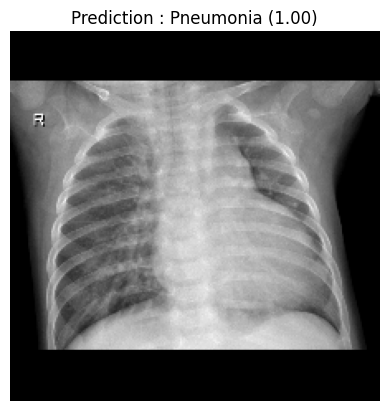

In [29]:
# Mapping des classes
label_name = {0: "Normal", 1: "Pneumonia"}

# Choix al√©atoire d'une image dans X_test
img_to_predict = random.randint(0, len(X_test) - 1)

# Obtenir la pr√©diction (proba)
proba = model.predict(X_test[[img_to_predict]])[0][0]

# Classer selon le seuil 0.5
predicted_class = int(proba > 0.5)

# Afficher l‚Äôimage avec pr√©diction
plt.imshow(X_test_display[img_to_predict].astype(np.uint8))
plt.title(f"Prediction : {label_name[predicted_class]} ({proba:.2f})")
plt.axis("off")
plt.show()

_______________________________________________________________________________________________________________________________________________________

# 7. Mise en place du suivi MLFlow

Ici nous centralisons dans un dictionnaire les param√®tres qui nous int√©resse pour le suivi des exp√©riences.

In [24]:
params = {
    "model": "MobileNetV3Large",
    "input_shape": (224, 224, 3),
    "batch_size": batch_size,
    "epochs": nb_epochs,
    "optimizer": optimizer,
    "loss_function": loss_function,
    "early_stop_patience": early_stop.patience,
    "early_stop_monitor": early_stop.monitor,
    "early_stop_resto_best_weights": early_stop.restore_best_weights,
    "Two_phase_training": True
}

Nous suivons l'exp√©rience sous le format "**Pneumonia detection** + nom du mod√®le utilis√©".\
Nous enregistrons les *param√®tres* utilis√© en parcourant le dictionnaire d√©di√©, ainsi que l'√©valuation des diff√©rents m√©triques.\
Nous g√©n√©rons aussi des graphiques de suivi des *m√©triques de performance*, ainsi que la *matrice de confusion*, retrouvables dans l'onglet Artifacts de MLFlow.

In [32]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment("Pneumonia detection - MobileNetV3Large (ImageDataGenerator)")

with mlflow.start_run(run_name="Pneumonia detection - MobileNetV3Large"):
    
    for name, value in params.items():
        mlflow.log_param(name, str(value))

    mlflow.log_metric("val_loss", loss)
    mlflow.log_metric("val_accuracy", accuracy)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1_score", f1)

    def graph_metrics(history, recall, precision, f1, name):
        """Fonction permettant d'enregistrer les graphiques repr√©sentant les diff√©rentes m√©triques
            et de l'envoyer vers le serveur local MLflow

        Args:
            history : historique des √©valuations du mod√®le
            recall : √©valuation du recall du mod√®le
            precision : √©valuation de l'accuracy
            f1 : √©valuation du f1-score
            name (string): nom du fichier
        """

        plt.figure(figsize=(14, 4))

        # Graphique pr√©cision (accuracy)
        plt.subplot(1, 3, 1)
        plt.plot(history.history['accuracy'], label='train acc')
        plt.plot(history.history['val_accuracy'], label='val acc')
        plt.title("Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        # Graphique pertes (loss)
        plt.subplot(1, 3, 2)
        plt.plot(history.history['loss'], label='train loss')
        plt.plot(history.history['val_loss'], label='val loss')
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # Bar plot des m√©triques
        plt.subplot(1, 3, 3)
        metrics = ['Recall', 'Precision', 'F1-score']
        values = [recall, precision, f1]
        colors = ['skyblue', 'lightgreen', 'salmon']
        bars = plt.bar(metrics, values, color=colors)
        plt.ylim(0, 1)
        plt.title("Validation Metrics")

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center')

        # Sauvegarde et log des graphiques dans MLflow
        file_path = f"{name.replace(' ', '_')}_full_metrics.png"
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), file_path)
        plt.close()



    def log_confusion_and_roc(y_true, y_pred, y_proba, labels, filename="confusion_and_roc.png"):
        """
        Affiche et envoie sur MLflow la matrice de confusion et la courbe ROC dans une seule figure.

        Args:
            y_true : Valeurs r√©elles (0 ou 1)
            y_pred : Pr√©dictions binaires (0 ou 1)
            y_proba : Probabilit√©s pr√©dites (entre 0 et 1)
            labels : Liste des labels (ex : ["Normal", "Pneumonia"])
            filename (str): Nom du fichier √† logger dans MLflow
        """

        # Matrice de confusion
        cm = confusion_matrix(y_true, y_pred)

        # ROC
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)

        # Figure combin√©e
        plt.figure(figsize=(12, 5))

        # ====== Matrice de confusion ======
        plt.subplot(1, 2, 1)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Matrice de confusion")
        plt.colorbar()
        tick_marks = range(len(labels))
        plt.xticks(tick_marks, labels)
        plt.yticks(tick_marks, labels)
        plt.xlabel("Pr√©dictions")
        plt.ylabel("R√©el")
        for i in range(len(cm)):
            for j in range(len(cm[0])):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center", color="black")

        # ====== Courbe ROC ======
        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('Taux de faux positifs')
        plt.ylabel('Taux de vrais positifs')
        plt.title('Courbe ROC')
        plt.legend(loc="lower right")

        # Log sur MLflow
        plt.tight_layout()
        mlflow.log_figure(plt.gcf(), filename)
        plt.close()


    # Tracer et logger les graphes vers MLflow
    graph_metrics(history_nofreeze, recall, precision, f1, name="Results")
    log_confusion_and_roc(
    y_true=y_test,
    y_pred=y_pred,
    y_proba=y_pred_proba,
    labels=["Normal", "Pneumonia"]
)

    # ==============================
    # 4. Logger le mod√®le final
    # ==============================
    mlflow.keras.log_model(model, "MobileNetV3Small")


2025/05/27 16:20:08 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/27 16:20:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run Pneumonia detection - MobileNetV3Large at: http://127.0.0.1:5000/#/experiments/740987016087741830/runs/b63f3a849cf946b293c447328dbe507d
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/740987016087741830


Finalement, nous demandons √† l'utilisateur si il veut enregistrer ce mod√®le (ou un autre). Cela n√©cessite d'indiquer l'ID de l'exp√©rience associ√©e.

In [26]:
while True:
   register_model = input("Voulez vous enregistrer un mod√®le ? (y/n)")
   if register_model == "y":
      run_id = input("Indiquez l'id du mod√®le :")
      model_uri = f'runs:/{run_id}/{params["model"]}'
      result = mlflow.register_model(
         model_uri, params["model"]
      )
   else:
      break

Successfully registered model 'MobileNetV3Large'.
2025/05/27 14:30:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MobileNetV3Large, version 1
Created version '1' of model 'MobileNetV3Large'.
